In [29]:
import wandb
import pandas as pd
import numpy as np
import texttable as tt
import latextable

In [30]:
EXPERIMENT_GROUP = "best-model"
BASELINE_SETUP = "0"
AVERAGE_EPOCHS = 0 # 5 or 0 | 0 for no averaging, must be odd
HAS_WEIGHTED_ACCURACY = True
FIRST_N_METRICS = None #6 # Only weighted_accuracy and macro_f1 for the results table in experiment results section
EXCLUDED_SETUPS = [] # [0, 1] | list of setups to exclude, by their index in the list of setups

CONVSTAR_REF = True
GET_TEST_METRICS = True
EXCLUDED_SETUPS_NAMES = ['messis-test-overfit', 'messis-test-bl', 'messis-test']

In [46]:
def get_best_epoch_metrics(run, metric_name, average_epochs=0):
    history = pd.DataFrame(list(run.scan_history()))
    
    # Find the epoch with the best metric value
    best_epoch = history[metric_name].idxmax()
    best_metrics = history.loc[best_epoch]
    if average_epochs > 0:
        # Find indices of valid (non-NaN) values
        valid_indices = history[metric_name].dropna().index
        
        # Locate the best epoch index in the valid indices
        best_index_position = valid_indices.get_loc(best_epoch)
        
        # Get the indices of the average_epochs epochs to be averaged
        idx_adjustment = (average_epochs - 1) // 2
        start_index = max(0, best_index_position - idx_adjustment)
        end_index = min(len(valid_indices), best_index_position + idx_adjustment + 1)
        selected_indices = valid_indices[start_index:end_index]
        
        # Convert the selected indices to numeric, forcing errors to NaN - Use when averaging over epchs
        # converted_history = history.loc[selected_indices].apply(pd.to_numeric, errors='coerce')
        # converted_history.mean()

        # Average the metrics over the selected epochs
        averaged_metrics = history.loc[selected_indices].mean()
        
        print(f"Run {run.url} - Best epoch: {best_epoch} (averaged over {average_epochs}) - {metric_name}: {averaged_metrics[metric_name]}")
        return averaged_metrics, best_epoch
    else:
        print(f"Run {run.url} - Best epoch: {best_epoch} - {metric_name}: {best_metrics[metric_name]}")
        return best_metrics, best_epoch
    
def get_test_metrics(run):
    history = pd.DataFrame(list(run.scan_history()))
    
    # Find the trainign step with the test metric values
    test_step = history['test_f1_tier3_majority'].idxmax()
    test_metrics = history.loc[test_step]
    
    print(f"Run {run.url} - Test training step: {test_step} - test_f1_tier3_majority: {test_metrics['test_f1_tier3_majority']}")
    return test_metrics

def gather_metrics_for_experiment_group(experiment_group, average_epochs=0, has_weighted_accuracy=True):
    api = wandb.Api(timeout=60)

    # Fetch runs matching the experiment group
    runs = api.runs("crop-classification/messis", filters={"config.experiment_group": experiment_group})
    print(f"Found {len(runs)} runs for experiment group '{experiment_group}'")

    # Organize the runs by setup name
    setups = {}
    for run in runs:
        if run.state != 'finished':
            print(f"Run {run.url} - Skipping (not finished, state: {run.state})")
            continue
        if 'name' not in run.config:
            if 'experiment_name' in run.config:
                setup_name = run.config['experiment_name'].split('-')[-1]
                print(f"Run {run.url} - Missing 'name' in config, getting it from 'experiment_name' instead: {setup_name}")
            else:
                print(f"Run {run.url} - Missing 'name' in config, skipping")
                continue
        else:
            setup_name = run.config['name']
        # Skip if EXCLUDED_SETUPS_NAMES contains the full setup name
        if setup_name in EXCLUDED_SETUPS_NAMES:
            print(f"Run {run.url} - Skipping (excluded setup)")
            continue
        if setup_name not in setups:
            setups[setup_name] = {
                'runs': [],
                'metrics': {metric: [] for metric in [
                    'val_f1_tier1_majority',
                    'val_f1_tier2_majority',
                    'val_f1_tier3_majority',
                    'val_weighted_accuracy_tier1_majority' if has_weighted_accuracy else 'val_accuracy_tier1_majority',
                    'val_weighted_accuracy_tier2_majority' if has_weighted_accuracy else 'val_accuracy_tier2_majority',
                    'val_weighted_accuracy_tier3_majority' if has_weighted_accuracy else 'val_accuracy_tier3_majority',
                    'val_precision_tier1_majority',
                    'val_precision_tier2_majority',
                    'val_precision_tier3_majority',
                    'val_recall_tier1_majority',
                    'val_recall_tier2_majority',
                    'val_recall_tier3_majority',
                    'val_cohen_kappa_tier1_majority',
                    'val_cohen_kappa_tier2_majority',
                    'val_cohen_kappa_tier3_majority',
                ]},
                'best_steps': []
            }
        setups[setup_name]['runs'].append(run)

    # If GET_TEST_METRICS is enabled, initialize the test metrics
    if GET_TEST_METRICS:
        for setup_data in setups.values():
            new_metrics = []
            for metric in setup_data['metrics']:
                test_metric = metric.replace('val_', 'test_')
                new_metrics.append(test_metric)
            for test_metric in new_metrics:
                setup_data['metrics'][test_metric] = []

    # Print setup names with number of runs
    for setup_name, setup_data in setups.items():
        print(f"Setup '{setup_name}' - {len(setup_data['runs'])} runs")

    # Gather metrics for each setup
    for setup_name, setup_data in setups.items():
        for run in setup_data['runs']:
            best_metrics, best_epoch = get_best_epoch_metrics(run, 'val_f1_tier3_majority' if (setup_name != 'seasonality' and setup_name != 'seasonality-reduced') else 'val_f1_tier2_majority', average_epochs)
            setup_data['best_steps'].append(best_epoch)
            for metric in setup_data['metrics']:
                # Skip metrics that are not present in the best_metrics
                if metric not in best_metrics:
                    print(f"Run {run.url} - Skipping metric '{metric}' (not present in run)")
                    continue
                setup_data['metrics'][metric].append(best_metrics[metric])

            if GET_TEST_METRICS:
                test_metrics = get_test_metrics(run)

                for metric in setup_data['metrics']:
                    test_metric = metric.replace('val_', 'test_')
                    if test_metric not in test_metrics:
                        print(f"Run {run.url} - Skipping metric '{test_metric}' (not present in run)")
                        continue
                    value = test_metrics[test_metric]
                    # if value not numeric, print
                    if not isinstance(value, (int, float)):
                        print(f"Run {run.url} - Test metric '{test_metric}': {value}")
                    setup_data['metrics'][test_metric].append(test_metrics[test_metric])
    
    # Prepare data for DataFrame
    data = []
    for setup_name, setup_data in setups.items():
        metrics_summary = {
            'setup': setup_name,
            'num_runs': len(setup_data['runs']),
            'average_epochs': average_epochs,
            'run_handles': [run.id for run in setup_data['runs']],
            'best_steps': setup_data['best_steps'],
        }
        for metric, values in setup_data['metrics'].items():
            if 'test' in metric:
                # NOTE: For some reason, the test metrics are duplicate and have NaN values inebtween? Temporarily fix this
                # drop nan values
                values = [x for x in values if not pd.isna(x)]
                # drop duplicates in values
                values = list(dict.fromkeys(values))
                # assert there are 5 values remaining
                assert len(values) == 5

            metrics_summary[f'{metric}_mean'] = np.mean(values)
            metrics_summary[f'{metric}_std'] = np.std(values)
        data.append(metrics_summary)
    
    metrics_df = pd.DataFrame(data)
    
    return metrics_df

# Run the function for a given experiment group
metrics_df = gather_metrics_for_experiment_group(EXPERIMENT_GROUP, average_epochs=AVERAGE_EPOCHS, has_weighted_accuracy=HAS_WEIGHTED_ACCURACY)

# Add ConvSTAR reference results if needed
if CONVSTAR_REF:
    new_data = pd.DataFrame([{
        'setup': 'ms-convSTAR',
        'num_runs': 5,
        'average_epochs': 0,
        'run_handles': [],
        'val_f1_tier1_majority_mean': 0.57,
        'val_f1_tier2_majority_mean': 0.545,
        'val_f1_tier3_majority_mean': 0.524,
        'val_precision_tier1_majority_mean': 0.803,
        'val_precision_tier2_majority_mean': 0.730,
        'val_precision_tier3_majority_mean': 0.601,
        'val_recall_tier1_majority_mean': 0.529,
        'val_recall_tier2_majority_mean': 0.510,
        'val_recall_tier3_majority_mean': 0.498,
        'val_weighted_accuracy_tier1_majority_mean': 0.963,
        'val_weighted_accuracy_tier2_majority_mean': 0.892,
        'val_weighted_accuracy_tier3_majority_mean': 0.880,
    }])
    
    metrics_df = pd.concat([metrics_df, new_data], ignore_index=True)

# Save the DataFrame to a CSV file
metrics_df.to_csv(f"experiment_results/eval_{EXPERIMENT_GROUP}.csv", index=False)

metrics_df

Found 8 runs for experiment group 'best-model'
Run https://wandb.ai/crop-classification/messis/runs/sr29ovjh - Skipping (excluded setup)
Run https://wandb.ai/crop-classification/messis/runs/psqr1xcn - Skipping (excluded setup)
Run https://wandb.ai/crop-classification/messis/runs/sazfblml - Skipping (excluded setup)
Setup 'messis' - 5 runs
Run https://wandb.ai/crop-classification/messis/runs/n9z6i8xn - Best epoch: 1964 - val_f1_tier3_majority: 0.36320412158966064
Run https://wandb.ai/crop-classification/messis/runs/n9z6i8xn - Test training step: 2415 - test_f1_tier3_majority: 0.33064594864845276
Run https://wandb.ai/crop-classification/messis/runs/3d24y391 - Best epoch: 1922 - val_f1_tier3_majority: 0.3587850034236908
Run https://wandb.ai/crop-classification/messis/runs/3d24y391 - Test training step: 2374 - test_f1_tier3_majority: 0.36047762632369995
Run https://wandb.ai/crop-classification/messis/runs/x02mnw32 - Best epoch: 2995 - val_f1_tier3_majority: 0.3541222810745239
Run https://w

setup  num_runs  average_epochs  \
0       messis         5               0   
1  ms-convSTAR         5               0   

                                         run_handles  \
0  [n9z6i8xn, 3d24y391, x02mnw32, new9ykv7, z5nrj...   
1                                                 []   

                       best_steps  val_f1_tier1_majority_mean  \
0  [1964, 1922, 2995, 2170, 2170]                    0.626808   
1                             NaN                    0.570000   

   val_f1_tier1_majority_std  val_f1_tier2_majority_mean  \
0                   0.072841                    0.422705   
1                        NaN                    0.545000   

   val_f1_tier2_majority_std  val_f1_tier3_majority_mean  ...  \
0                   0.036581                    0.359075  ...   
1                        NaN                    0.524000  ...   

   test_recall_tier2_majority_mean  test_recall_tier2_majority_std  \
0                         0.374308                        0.014735   
1                              NaN                             NaN   

   test_recall_tier3_majority_mean  test_recall_tier3_majority_std  \
0                         0.316809                        0.008642   
1                              NaN                             NaN   

   test_cohen_kappa_tier1_majority_mean  test_cohen_kappa_tier1_majority_std  \
0                              0.911694                             0.001746   
1                                   NaN                                  NaN   

   test_cohen_kappa_tier2_majority_mean  test_cohen_kappa_tier2_majority_std  \
0                              0.793946                             0.002937   
1                                   NaN                                  NaN   

   test_cohen_kappa_tier3_majority_mean  test_cohen_kappa_tier3_majority_std  
0                               0.76389                             0.003716  
1                                   NaN                                  NaN  

[2 rows x 65 columns]

In [66]:
# Mapping for short metric names
metric_name_mapping = {
    'val_f1_tier1_majority': 'F1 $T_1$',
    'val_f1_tier2_majority': 'F1 $T_2$',
    'val_f1_tier3_majority': 'F1 $T_3$',
}

if HAS_WEIGHTED_ACCURACY:
    metric_name_mapping['val_weighted_accuracy_tier1_majority'] = 'W. Acc. $T_1$'
    metric_name_mapping['val_weighted_accuracy_tier2_majority'] = 'W. Acc. $T_2$'
    metric_name_mapping['val_weighted_accuracy_tier3_majority'] = 'W. Acc. $T_3$'
else:
    metric_name_mapping['val_accuracy_tier1_majority'] = 'Acc. $T_1$'
    metric_name_mapping['val_accuracy_tier2_majority'] = 'Acc. $T_2$'
    metric_name_mapping['val_accuracy_tier3_majority'] = 'Acc. $T_3$'

metric_name_mapping = { # Adding further metrics down here, to make sure we keep the most relevant metrics at the top
    **metric_name_mapping,
    'val_precision_tier1_majority': 'Precision $T_1$',
    'val_precision_tier2_majority': 'Precision $T_2$',
    'val_precision_tier3_majority': 'Precision $T_3$',
    'val_recall_tier1_majority': 'Recall $T_1$',
    'val_recall_tier2_majority': 'Recall $T_2$',
    'val_recall_tier3_majority': 'Recall $T_3$',
    'val_cohen_kappa_tier1_majority': 'Kappa $T_1$',
    'val_cohen_kappa_tier2_majority': 'Kappa $T_2$',
    'val_cohen_kappa_tier3_majority': 'Kappa $T_3$',
}

# Function to create a LaTeX table with bold best scores and underlined second-best scores
def create_latex_table(df, baseline_setup, first_n_metrics=None):
    metrics = list(metric_name_mapping.keys())
    if first_n_metrics:
        metrics = metrics[:first_n_metrics]
    
    # Determine the best and second-best scores for each metric
    best_scores = {metric: df[f'{metric}_mean'].max() for metric in metrics}
    second_best_scores = {
        metric: sorted(df[f'{metric}_mean'].unique(), reverse=True)[1] if len(df[f'{metric}_mean'].unique()) > 1 else None
        for metric in metrics
    }

    # Reorder the dataframe to have the baseline setup first
    df = df.set_index('setup')
    if baseline_setup in df.index:
        df = df.loc[[baseline_setup] + [idx for idx in df.index if idx != baseline_setup]].reset_index()
    else:
        df = df.reset_index()

    # Initialize the Texttable object
    table = tt.Texttable()
    
    # Define the header
    headers = ['Metric'] + [f"{'$\\dagger$ ' if row['setup'] == baseline_setup else ''}{str(setup).replace('_', '\\_')} ({row['num_runs']}-fold)" 
                            for idx, row in df.iterrows() for setup in [row['setup']]]
    table.header(headers)
    
    # Set alignment for columns
    cols_align = ["c"] * len(headers)
    cols_align[0] = "l"
    table.set_cols_align(cols_align)
    
    # Populate the table with data
    for metric in metrics:
        row_data = [metric_name_mapping[metric]]
        for idx, row in df.iterrows():
            mean = row[f'{metric}_mean'] * 100
            std = row[f'{metric}_std'] * 100
            value = f'{mean:.1f}\\% ± {std:.1f}\\%'
            if mean == best_scores[metric] * 100:
                value = f'\\textbf{{{value}}}'
            elif second_best_scores[metric] and mean == second_best_scores[metric] * 100:
                value = f'\\underline{{{value}}}'
            row_data.append(value)
        table.add_row(row_data)
    
    # Generate the LaTeX table
    average_epochs_used = df['average_epochs'].iloc[0] 
    caption_averaged =  "" if average_epochs_used == 0 else f" averaged over {average_epochs_used} epochs"
    latex_table = latextable.draw_latex(
        table, 
        caption=f"Results for experiment {EXPERIMENT_GROUP}. All metrics calculated on field majority during validation phase{caption_averaged}, with mean and std reported. Best scores bold, second best underlined, $\\dagger$ is baseline.", 
        label=f"tab:metrics_comparison_{EXPERIMENT_GROUP}", 
        use_booktabs=True,
        position="h"
    )

    # Add \resizebox to the LaTeX table
    latex_table = latex_table.replace('\\begin{center}', '\\begin{center}\\resizebox{\\textwidth}{!}{')
    latex_table = latex_table.replace('\\end{center}', '}\\end{center}')

    return latex_table

# Generate the LaTeX table
df_per_class_metrics = pd.read_csv(f"experiment_results/eval_{EXPERIMENT_GROUP}.csv")
df_per_class_metrics = df_per_class_metrics.sort_values(by='setup')

# Optional: Drop rows to exclude some setups
df_per_class_metrics = df_per_class_metrics.drop(EXCLUDED_SETUPS)

latex_table = create_latex_table(df_per_class_metrics, baseline_setup=BASELINE_SETUP, first_n_metrics=FIRST_N_METRICS)
print(latex_table)

\begin{table}[h]
	\begin{center}\resizebox{\textwidth}{!}{
		\begin{tabular}{lcc}
			\toprule
			Metric & messis (5-fold) & ms-convSTAR (5-fold) \\
			\midrule
			F1 $T_1$ & \textbf{62.7\% ± 7.3\%} & \underline{57.0\% ± nan\%} \\
			F1 $T_2$ & \underline{42.3\% ± 3.7\%} & \textbf{54.5\% ± nan\%} \\
			F1 $T_3$ & \underline{35.9\% ± 0.6\%} & \textbf{52.4\% ± nan\%} \\
			W. Acc. $T_1$ & \underline{95.6\% ± 0.2\%} & \textbf{96.3\% ± nan\%} \\
			W. Acc. $T_2$ & \underline{86.3\% ± 0.5\%} & \textbf{89.2\% ± nan\%} \\
			W. Acc. $T_3$ & \underline{83.6\% ± 0.7\%} & \textbf{88.0\% ± nan\%} \\
			Precision $T_1$ & \underline{78.6\% ± 5.4\%} & \textbf{80.3\% ± nan\%} \\
			Precision $T_2$ & \underline{55.4\% ± 4.3\%} & \textbf{73.0\% ± nan\%} \\
			Precision $T_3$ & \underline{46.6\% ± 1.6\%} & \textbf{60.1\% ± nan\%} \\
			Recall $T_1$ & \textbf{57.6\% ± 7.6\%} & \underline{52.9\% ± nan\%} \\
			Recall $T_2$ & \underline{39.0\% ± 3.6\%} & \textbf{51.0\% ± nan\%} \\
			Recall $T_3$ & \underli

In [ ]:
if not CONVSTAR_REF:
    # deserialize best_steps column in df to list
    df_per_class_metrics['best_steps'] = df_per_class_metrics['best_steps'].apply(eval)

    # calculate mean and std for each list in column best_steps
    df_per_class_metrics['best_steps_mean'] = df_per_class_metrics['best_steps'].apply(np.mean)
    df_per_class_metrics['best_steps_std'] = df_per_class_metrics['best_steps'].apply(np.std)

    # show columns setup, best_steps_mean and num_runs
    df_per_class_metrics[['setup', 'best_steps_mean', 'best_steps_std', 'num_runs']]

In [69]:
# Produce Table for Best Model
if GET_TEST_METRICS:
    df_per_class_metrics = pd.read_csv(f"experiment_results/eval_best-model.csv")

    # Step 1: Identify all columns that start with 'test_'
    test_columns = [col for col in df_per_class_metrics.columns if col.startswith('test_')]

    # Step 2: Extract these columns into a new DataFrame
    test_metrics_df = df_per_class_metrics[['setup'] + test_columns].copy()

    # Step 3: Modify the "setup" value in this new DataFrame to include "[test]"
    test_metrics_df['setup'] = test_metrics_df['setup'] + ' [test]'
    test_metrics_df['num_runs'] = 5

    # Step 4: Rename the 'test_' columns to 'val_' in this new DataFrame
    test_metrics_df.rename(columns=lambda x: x.replace('test_', 'val_') if x.startswith('test_') else x, inplace=True)

    # Step 5: Remove the 'test_' columns from the original DataFrame
    df_per_class_metrics = df_per_class_metrics.drop(columns=test_columns)

    # Step 6: Append the new DataFrame to the original DataFrame
    result_df = pd.concat([df_per_class_metrics, test_metrics_df], ignore_index=True)

    # Drop loc 3
    result_df = result_df.drop(3)

    # Order by setup name
    result_df = result_df.sort_values(by='setup')

    # Make table with test metrics
    latex_table = create_latex_table(result_df, baseline_setup=BASELINE_SETUP, first_n_metrics=FIRST_N_METRICS)
    print(latex_table)

\begin{table}[h]
	\begin{center}\resizebox{\textwidth}{!}{
		\begin{tabular}{lccc}
			\toprule
			Metric & messis (5-fold) & messis [test] (5-fold) & ms-convSTAR (5-fold) \\
			\midrule
			F1 $T_1$ & \underline{62.7\% ± 7.3\%} & \textbf{64.0\% ± 2.3\%} & 57.0\% ± nan\% \\
			F1 $T_2$ & \underline{42.3\% ± 3.7\%} & 40.1\% ± 1.5\% & \textbf{54.5\% ± nan\%} \\
			F1 $T_3$ & \underline{35.9\% ± 0.6\%} & 34.8\% ± 1.4\% & \textbf{52.4\% ± nan\%} \\
			W. Acc. $T_1$ & \underline{95.6\% ± 0.2\%} & 95.5\% ± 0.1\% & \textbf{96.3\% ± nan\%} \\
			W. Acc. $T_2$ & \underline{86.3\% ± 0.5\%} & 85.6\% ± 0.4\% & \textbf{89.2\% ± nan\%} \\
			W. Acc. $T_3$ & \underline{83.6\% ± 0.7\%} & 82.9\% ± 0.5\% & \textbf{88.0\% ± nan\%} \\
			Precision $T_1$ & 78.6\% ± 5.4\% & \textbf{83.5\% ± 2.9\%} & \underline{80.3\% ± nan\%} \\
			Precision $T_2$ & \underline{55.4\% ± 4.3\%} & 50.6\% ± 1.5\% & \textbf{73.0\% ± nan\%} \\
			Precision $T_3$ & \underline{46.6\% ± 1.6\%} & 44.2\% ± 3.6\% & \textbf{60.1\% ± nan\%

## Per-Class Metrics

In [213]:
import pandas as pd
import numpy as np
import json

Load the ZueriCrop 2.0 labels hierarchy and extend it with the pixel count present within the dataset.

In [160]:
# Labels hierarchy
labels_hierarchy = pd.read_csv('../data/labels_hierarchy.csv')

# Drop tier_1 and rename tier_2 to tier_1 etc.
labels_hierarchy = labels_hierarchy.drop(columns=['tier_1'])
labels_hierarchy = labels_hierarchy.rename(columns={'tier_2': 'tier_1', 'tier_3': 'tier_2', 'tier_4': 'tier_3'})

with open('experiment_results/zueri_crop_2.0_dataset_pixel_counts.json') as f:
    dataset_pixel_counts = json.load(f)

with open('../data/dataset_info.json') as f:
    dataset_info = json.load(f)

print(dataset_pixel_counts)
print(dataset_info)

# Adding the index position of each class within the dataset_info
for tier in ['tier_1', 'tier_2', 'tier_3']:
    tier_key = tier.replace('_', '')  # Convert 'tier_1' to 'tier1' to match dataset_info keys
    labels_hierarchy[f'{tier}_idx'] = labels_hierarchy[tier].apply(lambda x: dataset_info[tier_key].index(x) if x in dataset_info[tier_key] else -1)

# Adding the pixel counts for each tier
for tier in ['tier_1', 'tier_2', 'tier_3']:
    tier_key = tier.replace('_', '')  # Convert 'tier_1' to 'tier1' to match dataset_info keys
    pixel_count_col = f'{tier}_pixel_count'
    labels_hierarchy[pixel_count_col] = labels_hierarchy[f'{tier}_idx'].apply(lambda x: dataset_pixel_counts[tier_key].get(str(x), 0) if x != -1 else 0)

print(len(labels_hierarchy))
labels_hierarchy.head()

{'tier1': {'0': 13467025, '1': 4389610, '3': 121739, '4': 80642, '2': 3453813, '5': 12675}, 'tier2': {'0': 13467025, '1': 3775380, '4': 610564, '7': 110454, '9': 32898, '2': 1414999, '3': 860419, '5': 934733, '6': 236442, '8': 29910, '10': 16930, '13': 3666, '14': 12675, '15': 834, '11': 11285, '12': 7220, '16': 70}, 'tier3': {'0': 13467025, '1': 3775380, '4': 610564, '12': 62957, '15': 32898, '2': 900795, '3': 854471, '5': 357107, '6': 296026, '8': 227894, '9': 138339, '14': 29910, '7': 266612, '10': 99072, '11': 87624, '20': 16930, '13': 58027, '16': 32738, '17': 30330, '19': 16941, '22': 12662, '24': 10784, '26': 7331, '28': 5948, '33': 3666, '34': 12675, '35': 3717, '44': 834, '21': 12815, '25': 11285, '27': 7220, '36': 3982, '43': 970, '18': 26632, '30': 6515, '40': 2083, '29': 3583, '23': 10375, '47': 70, '32': 4810, '31': 6266, '45': 320, '37': 2033, '38': 2351, '39': 1771, '41': 1756, '42': 1151, '46': 248, '48': 11}}
{'tier1': ['Background', 'Grassland', 'Field crops', 'Orchar

,tier_1,tier_2,tier_3,pixel_count,label_ids,lnf_codes,label_slug,tier_1_idx,tier_2_idx,tier_3_idx,tier_1_pixel_count,tier_2_pixel_count,tier_3_pixel_count
0,Grassland,Meadow,Meadow,3249831,"['58', '59', '60', '61', '62', '66', '67', '71']","['601', '602', '611', '612', '613', '621', '62...",Vegetation_Grassland_Meadow_Meadow,1,1,1,4389610,3775380,3775380
1,Field crops,SmallGrainCereal,WinterWheat,837126,['10'],['513'],Vegetation_Field crops_SmallGrainCereal_Winter...,2,2,2,3453813,1414999,900795
2,Field crops,LargeGrainCereal,Maize,809566,"['7', '14', '15']","['508', '519', '521']",Vegetation_Field crops_LargeGrainCereal_Maize,2,3,3,3453813,860419,854471
3,Grassland,Pasture,Pasture,505770,"['63', '64', '65', '68', '123']","['616', '617', '618', '625', '930']",Vegetation_Grassland_Pasture_Pasture,1,4,4,4389610,610564,610564
4,Field crops,BroadLeafRowCrop,Sugar_beets,295998,['16'],['522'],Vegetation_Field crops_BroadLeafRowCrop_Sugar_...,2,5,5,3453813,934733,357107


In [167]:
def load_wb_per_class_metrics_table(path, tier='tier_3'):
    file_path = path
    df_per_class_metrics = pd.read_csv(file_path)

    tier_name = 'Tier 3' if tier == 'tier_3' else 'Tier 2' if tier == 'tier_2' else 'Tier 1'

    # Adding the 'fold' column to the dataframe
    df_per_class_metrics['Fold'] = df_per_class_metrics.groupby('Class Index').cumcount()

    # Calculating mean and standard deviation for each metric column over the 5 folds
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    mean_std_df = df_per_class_metrics.groupby('Class Index')[metrics].agg(['mean', 'std']).reset_index()

    # Flattening the MultiIndex columns
    mean_std_df.columns = [' '.join(col).strip() for col in mean_std_df.columns.values]

    # Join mean_std_df with df_per_class_metrics to get the class name
    mean_std_df = mean_std_df.merge(df_per_class_metrics[['Class Index', 'Class Name', 'N']].drop_duplicates(), on='Class Index')

    # Add missign classes if tier is tier4
    if tier == 'tier_3':
        # Check discrepancies between labels_hierarchy and mean_std_df
        lh_set = set(labels_hierarchy[tier])
        ms_set = set(mean_std_df['Class Name'])

        missing_classes = lh_set - ms_set

        print('Adding entries for unrepresented classes:', missing_classes)

        # New rows for missing classes, with NaN values
        missing_df = pd.DataFrame([{
            'Class Index': -1,
            'Precision mean': None,
            'Precision std': None,
            'Recall mean': None,
            'Recall std': None,
            'F1 mean': None,
            'F1 std': None,
            'Accuracy mean': None,
            'Accuracy std': None,
            'N': 0,
            'Class Name': missing_class
        } for missing_class in missing_classes])

        # Drop columns with all-NA entries in missing_df to avoid future warnings
        missing_df = missing_df.dropna(axis=1, how='all')

        # Append the missing rows to the mean_std_df
        mean_std_df = pd.concat([mean_std_df, missing_df], ignore_index=True)

    # Merge columns tier_3 and tier_2 from labels_hierarchy
    mean_std_df = mean_std_df.merge(labels_hierarchy[['tier_3', 'tier_2', 'tier_1']], left_on='Class Name', right_on=tier, how='left')

    # Rename tier_3 to Tier 2 and tier_2 to Tier 1
    mean_std_df = mean_std_df.rename(columns={'tier_1': 'Tier 1', 'tier_2': 'Tier 2', 'tier_3': 'Tier 3'})

    # Order by Tier 1 
    mean_std_df = mean_std_df.sort_values(by=['Tier 1', 'Tier 2', 'Tier 3'])

    # Reorder columns
    mean_std_df = mean_std_df[['Tier 1', 'Tier 2', 'Tier 3', 'Class Name', 'N', 'Precision mean', 'Precision std', 'Recall mean', 'Recall std', 'F1 mean', 'F1 std', 'Accuracy mean', 'Accuracy std']]

    # Rename metrics columns to include tier name at beginning
    mean_std_df = mean_std_df.rename(columns={
        'Class Name': f'{tier_name} Class Name',
        'N': f'{tier_name} N',
        'Precision mean': f'{tier_name} Precision mean',
        'Precision std': f'{tier_name} Precision std',
        'Recall mean': f'{tier_name} Recall mean',
        'Recall std': f'{tier_name} Recall std',
        'F1 mean': f'{tier_name} F1 mean',
        'F1 std': f'{tier_name} F1 std',
        'Accuracy mean': f'{tier_name} Accuracy mean',
        'Accuracy std': f'{tier_name} Accuracy std',
    })

    # Reset index
    mean_std_df = mean_std_df.reset_index(drop=True)

    print('Resulting DataFrame length:', len(mean_std_df))
    return mean_std_df

df_tier_1_per_class_metrics = load_wb_per_class_metrics_table('experiment_results/messis_best-model_test_per_class_metrics_tier1_majority.csv', tier='tier_1')
df_tier_2_per_class_metrics = load_wb_per_class_metrics_table('experiment_results/messis_best-model_test_per_class_metrics_tier2_majority.csv', tier='tier_2')
df_tier_3_per_class_metrics = load_wb_per_class_metrics_table('experiment_results/messis_best-model_test_per_class_metrics_tier3_majority.csv', tier='tier_3')

df_tier_1_per_class_metrics

Resulting DataFrame length: 48
Resulting DataFrame length: 48
Adding entries for unrepresented classes: {'Chestnut', 'Mustard'}
Resulting DataFrame length: 48


,Tier 1,Tier 2,Tier 3,Tier 1 Class Name,Tier 1 N,Tier 1 Precision mean,Tier 1 Precision std,Tier 1 Recall mean,Tier 1 Recall std,Tier 1 F1 mean,Tier 1 F1 std,Tier 1 Accuracy mean,Tier 1 Accuracy std
0,Field crops,BroadLeafRowCrop,Beets,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
1,Field crops,BroadLeafRowCrop,Field bean,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
2,Field crops,BroadLeafRowCrop,Hemp,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
3,Field crops,BroadLeafRowCrop,Legumes,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
4,Field crops,BroadLeafRowCrop,Linen,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
5,Field crops,BroadLeafRowCrop,Lupine,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
6,Field crops,BroadLeafRowCrop,Mustard,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
7,Field crops,BroadLeafRowCrop,Peas,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
8,Field crops,BroadLeafRowCrop,Potatoes,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908
9,Field crops,BroadLeafRowCrop,Soy,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,0.001130,0.971347,0.000908


In [169]:
# Merge the three DataFrames
df_per_class_metrics = df_tier_1_per_class_metrics.merge(df_tier_2_per_class_metrics, on=['Tier 1', 'Tier 2', 'Tier 3'], how='outer')
df_per_class_metrics = df_per_class_metrics.merge(df_tier_3_per_class_metrics, on=['Tier 1', 'Tier 2', 'Tier 3'], how='outer')

# Additinally Merge Pixel counts from the Label Hierarchy
df_per_class_metrics = df_per_class_metrics.merge(labels_hierarchy[['tier_1', 'tier_2', 'tier_3', 'tier_1_pixel_count', 'tier_2_pixel_count', 'tier_3_pixel_count']], left_on=['Tier 1', 'Tier 2', 'Tier 3'], right_on=['tier_1', 'tier_2', 'tier_3'] , how='left')

# Drop the tier columns from the merge
df_per_class_metrics = df_per_class_metrics.drop(columns=['tier_1', 'tier_2', 'tier_3'])

# Rename pixel count columns
df_per_class_metrics = df_per_class_metrics.rename(columns={
    'tier_1_pixel_count': 'Tier 1 Pixel Count',
    'tier_2_pixel_count': 'Tier 2 Pixel Count',
    'tier_3_pixel_count': 'Tier 3 Pixel Count',
})

# Save the DataFrame to a CSV file
df_per_class_metrics.to_csv(f"experiment_results/messis_best-model_test_per_class_metrics.csv", index=False)
df_per_class_metrics

,Tier 1,Tier 2,Tier 3,Tier 1 Class Name,Tier 1 N,Tier 1 Precision mean,Tier 1 Precision std,Tier 1 Recall mean,Tier 1 Recall std,Tier 1 F1 mean,...,Tier 3 Precision std,Tier 3 Recall mean,Tier 3 Recall std,Tier 3 F1 mean,Tier 3 F1 std,Tier 3 Accuracy mean,Tier 3 Accuracy std,Tier 1 Pixel Count,Tier 2 Pixel Count,Tier 3 Pixel Count
0,Field crops,BroadLeafRowCrop,Beets,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.999743,0.000000e+00,3453813,934733,970
1,Field crops,BroadLeafRowCrop,Field bean,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.111402,0.716936,0.019336,0.775978,0.049603,0.999301,2.039933e-04,3453813,934733,12662
2,Field crops,BroadLeafRowCrop,Hemp,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.999330,0.000000e+00,3453813,934733,2083
3,Field crops,BroadLeafRowCrop,Legumes,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.547723,0.213714,0.324728,0.269659,0.388761,0.998766,5.096341e-04,3453813,934733,3982
4,Field crops,BroadLeafRowCrop,Linen,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.543758,0.325994,0.318539,0.416254,0.390848,0.998842,5.439938e-04,3453813,934733,3717
5,Field crops,BroadLeafRowCrop,Lupine,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.999962,0.000000e+00,3453813,934733,320
6,Field crops,BroadLeafRowCrop,Mustard,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3453813,934733,248
7,Field crops,BroadLeafRowCrop,Peas,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.082486,0.665748,0.136903,0.752865,0.097950,0.998314,5.033635e-04,3453813,934733,26632
8,Field crops,BroadLeafRowCrop,Potatoes,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.041707,0.659942,0.029081,0.733763,0.015404,0.991696,5.453622e-04,3453813,934733,138339
9,Field crops,BroadLeafRowCrop,Soy,Field crops,564584,0.965787,0.002104,0.967403,0.003727,0.966588,...,0.083604,0.502510,0.053266,0.619438,0.060447,0.997537,3.969970e-04,3453813,934733,30330


Choose columns to make the per-class metrics report table (on precision, or in Turkoglu's work accuracy)

In [264]:
df_per_class_metrics_turkoglu = pd.read_csv('./experiment_results/turkoglu_per_class_metrics.csv')

def clean_class_name(name):
    name = str(name)
    return re.sub(r'\s*\([^)]*\)', '', name).strip()

# Apply clean_class_name to all columns
df_per_class_metrics_turkoglu = df_per_class_metrics_turkoglu.map(clean_class_name)

# Type float
df_per_class_metrics_turkoglu = df_per_class_metrics_turkoglu.astype({'Tier 1 Accuracy': 'float', 'Tier 2 Accuracy': 'float', 'Tier 3 Accuracy': 'float'})

# Divide by 100 to get the percentage values
df_per_class_metrics_turkoglu['Tier 1 Accuracy'] = df_per_class_metrics_turkoglu['Tier 1 Accuracy'] / 100
df_per_class_metrics_turkoglu['Tier 2 Accuracy'] = df_per_class_metrics_turkoglu['Tier 2 Accuracy'] / 100
df_per_class_metrics_turkoglu['Tier 3 Accuracy'] = df_per_class_metrics_turkoglu['Tier 3 Accuracy'] / 100

# Rename columns
df_per_class_metrics_turkoglu = df_per_class_metrics_turkoglu.rename(columns={
    'Tier 1 Accuracy': 'Tier 1 Recall Turkoglu',
    'Tier 2 Accuracy': 'Tier 2 Recall Turkoglu',
    'Tier 3 Accuracy': 'Tier 3 Recall Turkoglu',
})

# Mark nan as NaN
df_per_class_metrics_turkoglu = df_per_class_metrics_turkoglu.replace('nan', np.nan)

# Forward fill on all columns
df_per_class_metrics_turkoglu = df_per_class_metrics_turkoglu.ffill()

df_per_class_metrics_turkoglu

,Tier 1,Tier 1 Recall Turkoglu,Tier 2,Tier 2 Recall Turkoglu,Tier 3,Tier 3 Recall Turkoglu
0,Field crops,0.982,SmallGrainCereal,0.977,SummerWheat,0.380
1,Field crops,0.982,SmallGrainCereal,0.977,WinterWheat,0.957
2,Field crops,0.982,SmallGrainCereal,0.977,Wheat,0.394
3,Field crops,0.982,SmallGrainCereal,0.977,EinkornWheat,0.498
4,Field crops,0.982,SmallGrainCereal,0.977,SummerBarley,0.261
5,Field crops,0.982,SmallGrainCereal,0.977,WinterBarley,0.964
6,Field crops,0.982,SmallGrainCereal,0.977,Grain,0.217
7,Field crops,0.982,SmallGrainCereal,0.977,Rye,0.681
8,Field crops,0.982,SmallGrainCereal,0.977,Spelt,0.840
9,Field crops,0.982,SmallGrainCereal,0.977,Oat,0.764


In [265]:
# Select Metrics needed for per-class performance table (Recall only)
df_per_class_metrics_recall = df_per_class_metrics[['Tier 1', 'Tier 1 Pixel Count', 'Tier 1 Recall mean', 'Tier 1 Recall std', 'Tier 2', 'Tier 2 Pixel Count', 'Tier 2 Recall mean', 'Tier 2 Recall std', 'Tier 3', 'Tier 3 Pixel Count', 'Tier 3 Recall mean', 'Tier 3 Recall std']].copy()

# Calculate the total pixel count for each tier
tier_1_total = df_per_class_metrics_recall['Tier 1 Pixel Count'].unique().sum()
tier_2_total = df_per_class_metrics_recall['Tier 2 Pixel Count'].unique().sum()
tier_3_total = df_per_class_metrics_recall['Tier 3 Pixel Count'].unique().sum()

# Calculate the percentage share for each class within each tier
df_per_class_metrics_recall.loc[:, 'Tier 1 Percentage Share'] = (df_per_class_metrics_recall['Tier 1 Pixel Count'] / tier_1_total)
df_per_class_metrics_recall.loc[:, 'Tier 2 Percentage Share'] = (df_per_class_metrics_recall['Tier 2 Pixel Count'] / tier_2_total)
df_per_class_metrics_recall.loc[:, 'Tier 3 Percentage Share'] = (df_per_class_metrics_recall['Tier 3 Pixel Count'] / tier_3_total)

# Assert that the sum of the percentage shares is 1 for each tier
assert df_per_class_metrics_recall['Tier 1 Percentage Share'].groupby(df_per_class_metrics_recall['Tier 1']).sum().all() == 1
assert df_per_class_metrics_recall['Tier 2 Percentage Share'].groupby(df_per_class_metrics_recall['Tier 2']).sum().all() == 1
assert df_per_class_metrics_recall['Tier 3 Percentage Share'].groupby(df_per_class_metrics_recall['Tier 3']).sum().all() == 1

# Add Turkoglu's results to the DataFrame
df_per_class_metrics_recall = df_per_class_metrics_recall.merge(df_per_class_metrics_turkoglu, on=['Tier 1', 'Tier 2', 'Tier 3'], how='left')

# New Column with diff betwen Messis Recall and Turkoglu's ms-ConvSTAR Recall
def format_recall_diff(diff):
    if diff > 0:
        return f"\\textcolor{{olive}}{{+{diff * 100:.2f}}}"
    elif diff < 0:
        return f"\\textcolor{{red}}{{{diff * 100:.2f}}}"
    else:
        return f"{diff * 100:.2f}"


df_per_class_metrics_recall['Tier 1 Recall Diff'] = df_per_class_metrics_recall['Tier 1 Recall mean'] - df_per_class_metrics_recall['Tier 1 Recall Turkoglu']
df_per_class_metrics_recall['Tier 2 Recall Diff'] = df_per_class_metrics_recall['Tier 2 Recall mean'] - df_per_class_metrics_recall['Tier 2 Recall Turkoglu']
df_per_class_metrics_recall['Tier 3 Recall Diff'] = df_per_class_metrics_recall['Tier 3 Recall mean'] - df_per_class_metrics_recall['Tier 3 Recall Turkoglu']

# To the right of each Tier 1, Tier 2 and Tier 3, add the relative percentage share of the pixel count in ()
df_per_class_metrics_recall['Tier 1'] = df_per_class_metrics_recall['Tier 1'] + ' (' + (df_per_class_metrics_recall['Tier 1 Percentage Share'] * 100).round(2).astype(str) + '%)' + df_per_class_metrics_recall['Tier 1 Recall Diff'].apply(lambda x: f" [{format_recall_diff(x)}]")
df_per_class_metrics_recall['Tier 2'] = df_per_class_metrics_recall['Tier 2'] + ' (' + (df_per_class_metrics_recall['Tier 2 Percentage Share'] * 100).round(2).astype(str) + '%)' + df_per_class_metrics_recall['Tier 2 Recall Diff'].apply(lambda x: f" [{format_recall_diff(x)}]")
df_per_class_metrics_recall['Tier 3'] = df_per_class_metrics_recall['Tier 3'] + ' (' + (df_per_class_metrics_recall['Tier 3 Percentage Share'] * 100).round(2).astype(str) + '%)' + df_per_class_metrics_recall['Tier 3 Recall Diff'].apply(lambda x: f" [{format_recall_diff(x)}]")

# New columns that combine mean and std for each metric in percentage format
df_per_class_metrics_recall['Tier 1 Recall'] = df_per_class_metrics_recall['Tier 1 Recall mean'].apply(lambda x: f"{x * 100:.2f}") + ' ± ' + df_per_class_metrics_recall['Tier 1 Recall std'].apply(lambda x: f"{x * 100:.2f}") 
df_per_class_metrics_recall['Tier 2 Recall'] = df_per_class_metrics_recall['Tier 2 Recall mean'].apply(lambda x: f"{x * 100:.2f}") + ' ± ' + df_per_class_metrics_recall['Tier 2 Recall std'].apply(lambda x: f"{x * 100:.2f}") 
df_per_class_metrics_recall['Tier 3 Recall'] = df_per_class_metrics_recall['Tier 3 Recall mean'].apply(lambda x: f"{x * 100:.2f}") + ' ± ' + df_per_class_metrics_recall['Tier 3 Recall std'].apply(lambda x: f"{x * 100:.2f}")

# Save the DataFrame to a CSV file
df_per_class_metrics_recall.to_csv(f"experiment_results/messis_best-model_test_per_class_metrics_recall.csv", index=False)

df_per_class_metrics_recall

,Tier 1,Tier 1 Pixel Count,Tier 1 Recall mean,Tier 1 Recall std,Tier 2,Tier 2 Pixel Count,Tier 2 Recall mean,Tier 2 Recall std,Tier 3,Tier 3 Pixel Count,...,Tier 3 Percentage Share,Tier 1 Recall Turkoglu,Tier 2 Recall Turkoglu,Tier 3 Recall Turkoglu,Tier 1 Recall Diff,Tier 2 Recall Diff,Tier 3 Recall Diff,Tier 1 Recall,Tier 2 Recall,Tier 3 Recall
0,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Beets (0.01%) [0.00],970,...,0.000120,0.982,0.951,0.000,-0.014597,-0.067353,0.000000,96.74 ± 0.37,88.36 ± 1.58,0.00 ± 0.00
1,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Field bean (0.16%) [\textcolor{red}{-16.61}],12662,...,0.001571,0.982,0.951,0.883,-0.014597,-0.067353,-0.166064,96.74 ± 0.37,88.36 ± 1.58,71.69 ± 1.93
2,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Hemp (0.03%) [\textcolor{red}{-3.10}],2083,...,0.000258,0.982,0.951,0.031,-0.014597,-0.067353,-0.031000,96.74 ± 0.37,88.36 ± 1.58,0.00 ± 0.00
3,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Legumes (0.05%) [\textcolor{red}{-56.63}],3982,...,0.000494,0.982,0.951,0.780,-0.014597,-0.067353,-0.566286,96.74 ± 0.37,88.36 ± 1.58,21.37 ± 32.47
4,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Linen (0.05%) [\textcolor{red}{-21.80}],3717,...,0.000461,0.982,0.951,0.544,-0.014597,-0.067353,-0.218006,96.74 ± 0.37,88.36 ± 1.58,32.60 ± 31.85
5,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Lupine (0.0%) [0.00],320,...,0.000040,0.982,0.951,0.000,-0.014597,-0.067353,0.000000,96.74 ± 0.37,88.36 ± 1.58,0.00 ± 0.00
6,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Mustard (0.0%) [nan],248,...,0.000031,0.982,0.951,0.000,-0.014597,-0.067353,NaN,96.74 ± 0.37,88.36 ± 1.58,nan ± nan
7,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Peas (0.33%) [\textcolor{red}{-15.83}],26632,...,0.003305,0.982,0.951,0.824,-0.014597,-0.067353,-0.158252,96.74 ± 0.37,88.36 ± 1.58,66.57 ± 13.69
8,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Potatoes (1.72%) [\textcolor{red}{-20.61}],138339,...,0.017167,0.982,0.951,0.866,-0.014597,-0.067353,-0.206058,96.74 ± 0.37,88.36 ± 1.58,65.99 ± 2.91
9,Field crops (42.86%) [\textcolor{red}{-1.46}],3453813,0.967403,0.003727,BroadLeafRowCrop (11.6%) [\textcolor{red}{-6.74}],934733,0.883647,0.015791,Soy (0.38%) [\textcolor{red}{-37.15}],30330,...,0.003764,0.982,0.951,0.874,-0.014597,-0.067353,-0.371490,96.74 ± 0.37,88.36 ± 1.58,50.25 ± 5.33


For report in LaTeX table, we want to remove redundant information.

In [266]:
df_per_class_metrics_recall_r = df_per_class_metrics_recall.copy()

# Select cols we still need
df_per_class_metrics_recall_r = df_per_class_metrics_recall_r[['Tier 1', 'Tier 1 Recall', 'Tier 2', 'Tier 2 Recall', 'Tier 3', 'Tier 3 Recall']]

# Function to keep the first entry for each tier and set the rest to NaN
def keep_first_entry(df, tier_column, precision_column):
    df[tier_column] = df[tier_column].where(df[tier_column].ne(df[tier_column].shift()))
    df[precision_column] = df[precision_column].where(df[tier_column].notna())
    return df

# Apply the function to each tier and corresponding precision column
df_per_class_metrics_recall_r = keep_first_entry(df_per_class_metrics_recall_r, 'Tier 1', 'Tier 1 Recall')
df_per_class_metrics_recall_r = keep_first_entry(df_per_class_metrics_recall_r, 'Tier 2', 'Tier 2 Recall')
df_per_class_metrics_recall_r = keep_first_entry(df_per_class_metrics_recall_r, 'Tier 3', 'Tier 3 Recall')

# Save the DataFrame to a CSV file
df_per_class_metrics_recall_r.to_csv(f"experiment_results/messis_best-model_test_per_class_metrics_recall_r.csv", index=False)

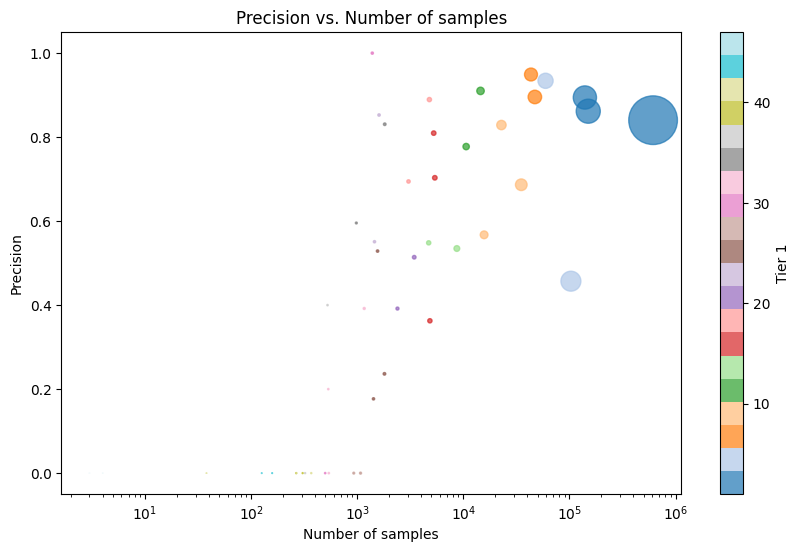

In [75]:
# Scatter Plot: Precision against N
import matplotlib.pyplot as plt

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(mean_std_df['N'], mean_std_df['Precision mean'], c=mean_std_df['Class Index'], cmap='tab20', s=mean_std_df['N'] / 500, alpha=0.7)
plt.xlabel('Number of samples')
plt.ylabel('Precision')
plt.title('Precision vs. Number of samples')
plt.colorbar(label='Tier 1')
plt.xscale('log')
plt.show()

## Not Pretrained vs. Frozen vs. Unfrozen

Found 20 runs for experiment name exp-4-backbone


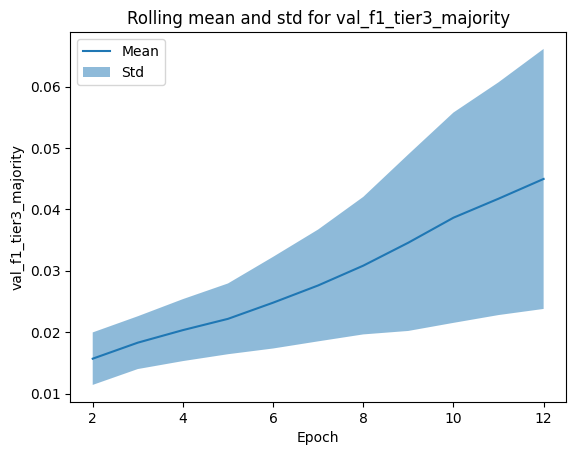

In [3]:
# %%
import wandb
import pandas as pd
import numpy as np


# %%
EXPERIMENT_GROUP = "exp-4-backbone"
METRIC = "val_f1_tier3_majority"
ROLLING_WINDOW = 5 # Number of epochs to average over for the uncertainty band

# %%
api = wandb.Api(timeout=60)

# %%
runs = api.runs("crop-classification/messis", filters={"config.experiment_group": EXPERIMENT_GROUP})
print(f"Found {len(runs)} runs for experiment name {EXPERIMENT_GROUP}")


# %%
f1s = []
min_len = float("inf")
for run in runs:
    history = pd.DataFrame(list(run.scan_history()))
    f1 = history[METRIC].values
    # Remove NaNs
    f1 = f1[~np.isnan(f1)]
    f1s.append(f1)
    min_len = min(min_len, len(f1))

f1s_for_band = [f1[:min_len] for f1 in f1s]

# %%
import matplotlib.pyplot as plt



f1s_for_band = np.array(f1s_for_band)
mean = np.mean(f1s_for_band, axis=0)
std = np.std(f1s_for_band, axis=0)

# Calculate rolling mean and std
rolling_mean = np.convolve(mean, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
rolling_std = np.convolve(std, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')

# plt.plot(rolling_mean, label="Mean")
plt.plot(np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2), rolling_mean, label="Mean")
# plt.fill_between(range(len(rolling_mean)), rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.25, label="Std")
plt.fill_between(np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2), rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.5, label="Std")

# plot the individual runs
# for f1 in f1s_for_band:
#     # use random color
#     color = np.random.rand(3)
#     plt.plot(f1[:min_len], alpha=0.5, color=color)
#     # with a dot at the end
#     plt.plot(min_len-1, f1[min_len-1], "o", color=color)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel(METRIC)
plt.title(f"Rolling mean and std for {METRIC}")
plt.show()


Found 20 runs for experiment name exp-4-backbone
Processing 5 runs for experiment name exp-4-backbone-not_pretrained-vles


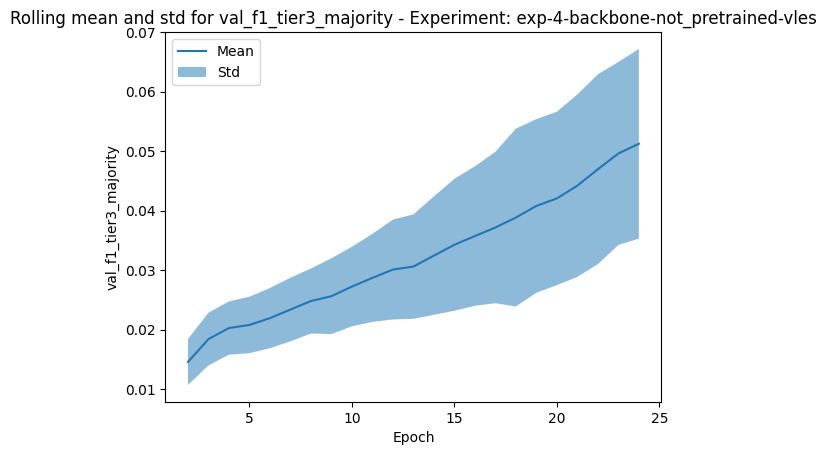

Processing 5 runs for experiment name exp-4-backbone-not_pretrained


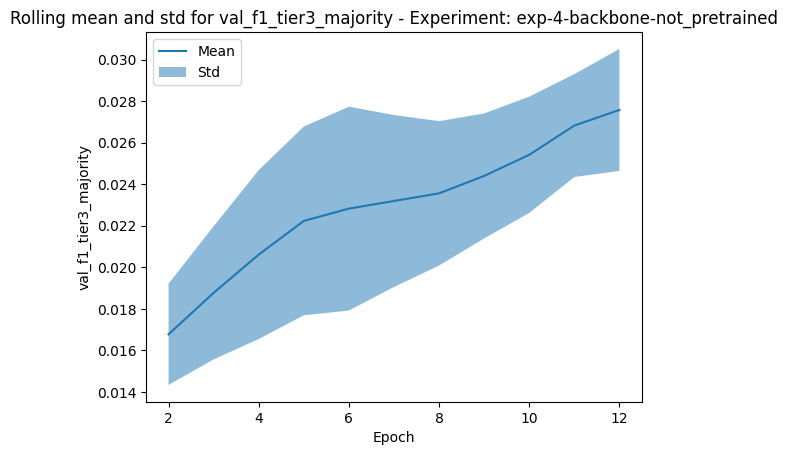

Processing 5 runs for experiment name exp-4-backbone-frozen


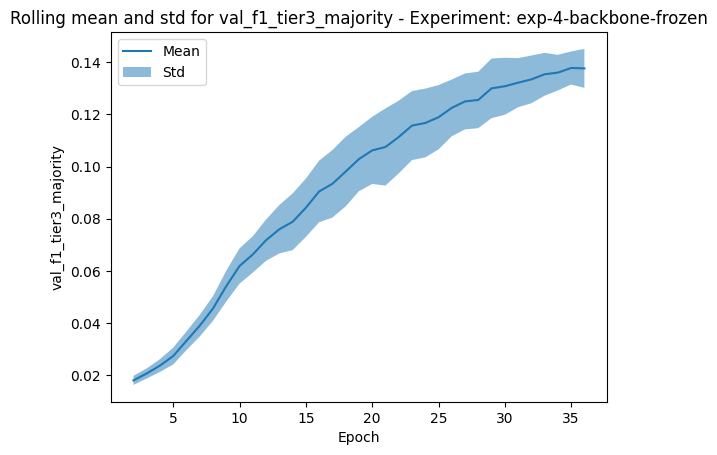

Processing 5 runs for experiment name exp-4-backbone-unfrozen


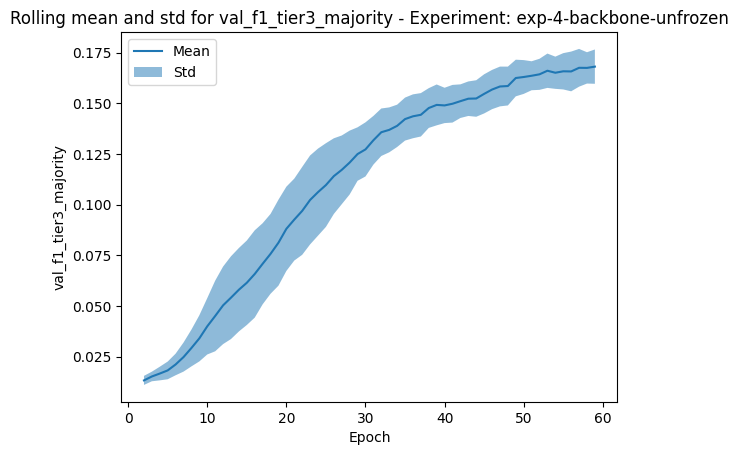

In [5]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants
METRIC = "val_f1_tier3_majority"
ROLLING_WINDOW = 5 # Number of epochs to average over for the uncertainty band

# Initialize the W&B API
api = wandb.Api(timeout=60)

# Fetch all runs
runs = api.runs("crop-classification/messis", filters={"config.experiment_group": EXPERIMENT_GROUP})
print(f"Found {len(runs)} runs for experiment name {EXPERIMENT_GROUP}")

# Group runs by their experiment name
runs_by_experiment = {}
for run in runs:
    experiment_name = run.config.get('experiment_name', 'unknown')
    if experiment_name not in runs_by_experiment:
        runs_by_experiment[experiment_name] = []
    runs_by_experiment[experiment_name].append(run)

# Drop expeirment exp-4-backbone-not_pretrained-vles
runs_by_experiment.pop('exp-4-backbone-not_pretrained-vles', None)

# Plot each experiment group separately
for experiment_name, runs in runs_by_experiment.items():
    print(f"Processing {len(runs)} runs for experiment name {experiment_name}")
    
    f1s = []
    min_len = float("inf")
    
    for run in runs:
        history = pd.DataFrame(list(run.scan_history()))
        f1 = history[METRIC].values
        # Remove NaNs
        f1 = f1[~np.isnan(f1)]
        f1s.append(f1)
        min_len = min(min_len, len(f1))

    f1s_for_band = [f1[:min_len] for f1 in f1s]
    
    if not f1s_for_band:  # Skip if no valid data
        continue
    
    f1s_for_band = np.array(f1s_for_band)
    mean = np.mean(f1s_for_band, axis=0)
    std = np.std(f1s_for_band, axis=0)

    # Calculate rolling mean and std
    rolling_mean = np.convolve(mean, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
    rolling_std = np.convolve(std, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')

    plt.figure()
    plt.plot(np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2), rolling_mean, label="Mean")
    plt.fill_between(np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2), rolling_mean - rolling_std, rolling_mean + rolling_std, alpha=0.5, label="Std")

    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(METRIC)
    plt.title(f"Rolling mean and std for {METRIC} - Experiment: {experiment_name}")
    plt.show()

Found 20 runs for experiment group exp-4-backbone
Processing 5 runs for experiment name exp-4-backbone-not_pretrained
Processing 5 runs for experiment name exp-4-backbone-frozen
Processing 5 runs for experiment name exp-4-backbone-unfrozen


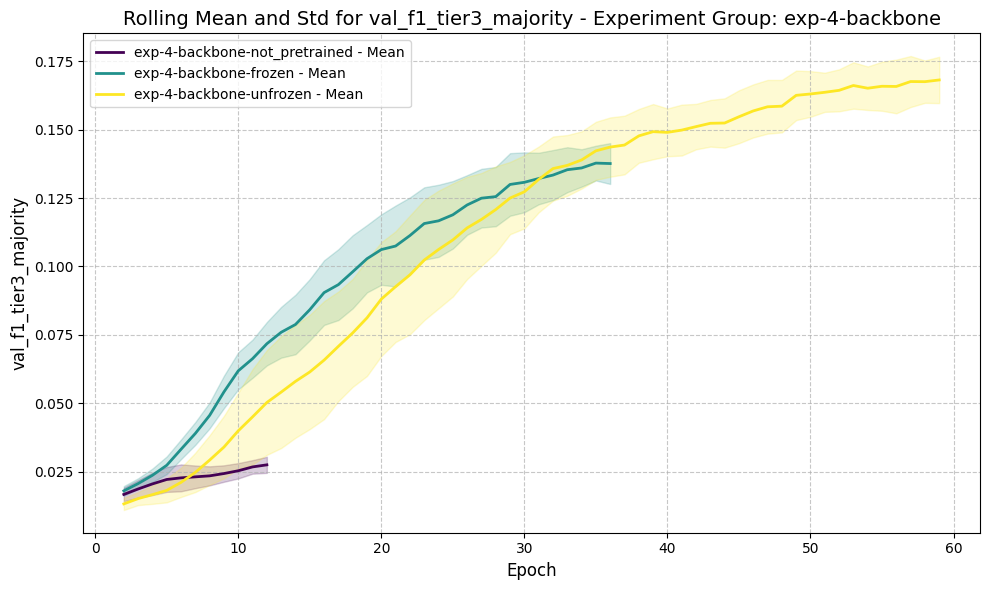

In [6]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Constants
EXPERIMENT_GROUP = "exp-4-backbone"
METRIC = "val_f1_tier3_majority"
ROLLING_WINDOW = 5 # Number of epochs to average over for the uncertainty band

# Initialize the W&B API
api = wandb.Api(timeout=60)

# Fetch all runs
runs = api.runs("crop-classification/messis", filters={"config.experiment_group": EXPERIMENT_GROUP})
print(f"Found {len(runs)} runs for experiment group {EXPERIMENT_GROUP}")

# Group runs by their experiment name
runs_by_experiment = {}
for run in runs:
    experiment_name = run.config.get('experiment_name', 'unknown')
    if experiment_name not in runs_by_experiment:
        runs_by_experiment[experiment_name] = []
    runs_by_experiment[experiment_name].append(run)

# Drop experiment exp-4-backbone-not_pretrained-vles
runs_by_experiment.pop('exp-4-backbone-not_pretrained-vles', None)

# Set up the plot
plt.figure(figsize=(10, 6))

colors = iter(cm.viridis(np.linspace(0, 1, len(runs_by_experiment))))

# Plot each experiment group on the same plot
for experiment_name, runs in runs_by_experiment.items():
    print(f"Processing {len(runs)} runs for experiment name {experiment_name}")
    
    f1s = []
    min_len = float("inf")
    
    for run in runs:
        history = pd.DataFrame(list(run.scan_history()))
        f1 = history[METRIC].values
        # Remove NaNs
        f1 = f1[~np.isnan(f1)]
        f1s.append(f1)
        min_len = min(min_len, len(f1))

    f1s_for_band = [f1[:min_len] for f1 in f1s]
    
    if not f1s_for_band:  # Skip if no valid data
        continue
    
    f1s_for_band = np.array(f1s_for_band)
    mean = np.mean(f1s_for_band, axis=0)
    std = np.std(f1s_for_band, axis=0)

    # Calculate rolling mean and std
    rolling_mean = np.convolve(mean, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
    rolling_std = np.convolve(std, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')

    color = next(colors)
    
    epochs = np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2)
    
    plt.plot(epochs, rolling_mean, label=f"{experiment_name} - Mean", color=color, linewidth=2)
    plt.fill_between(epochs, rolling_mean - rolling_std, rolling_mean + rolling_std, color=color, alpha=0.2)

# Customize the plot
plt.legend(loc="best", fontsize=10)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel(METRIC, fontsize=12)
plt.title(f"Rolling Mean and Std for {METRIC} - Experiment Group: {EXPERIMENT_GROUP}", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


Found 20 runs for experiment group exp-4-backbone
Processing 5 runs for experiment name exp-4-backbone-not_pretrained
Processing 5 runs for experiment name exp-4-backbone-frozen


/var/folders/8s/7zgyk05565q9l208ztk8spw80000gn/T/ipykernel_33326/927590743.py:64: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(f1s_for_band, axis=0)
/Users/yvokeller/Library/Caches/pypoetry/virtualenvs/messis-bV8Bs8aq-py3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Processing 5 runs for experiment name exp-4-backbone-unfrozen


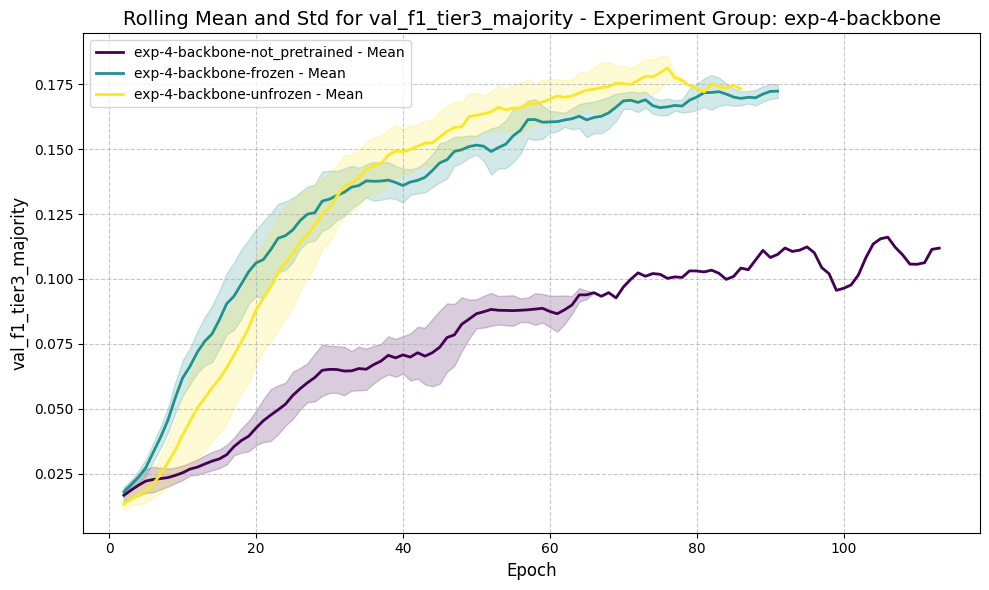

In [8]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Constants
EXPERIMENT_GROUP = "exp-4-backbone"
METRIC = "val_f1_tier3_majority"
ROLLING_WINDOW = 5 # Number of epochs to average over for the uncertainty band
TIMEOUT_SECONDS = 120  # Increase timeout for large datasets

# Initialize the W&B API with a longer timeout
api = wandb.Api(timeout=TIMEOUT_SECONDS)

# Fetch all runs
runs = api.runs("crop-classification/messis", filters={"config.experiment_group": EXPERIMENT_GROUP})
print(f"Found {len(runs)} runs for experiment group {EXPERIMENT_GROUP}")

# Group runs by their experiment name
runs_by_experiment = {}
for run in runs:
    experiment_name = run.config.get('experiment_name', 'unknown')
    if experiment_name not in runs_by_experiment:
        runs_by_experiment[experiment_name] = []
    runs_by_experiment[experiment_name].append(run)

# Drop experiment exp-4-backbone-not_pretrained-vles
runs_by_experiment.pop('exp-4-backbone-not_pretrained-vles', None)

# Find the maximum length of any run
max_len = 0
for runs in runs_by_experiment.values():
    for run in runs:
        history = pd.DataFrame(list(run.scan_history(keys=[METRIC], page_size=500)))  # Fetching with a smaller batch size
        max_len = max(max_len, len(history))

Processing 5 runs for experiment name exp-4-backbone-not_pretrained
Processing 5 runs for experiment name exp-4-backbone-frozen


/var/folders/8s/7zgyk05565q9l208ztk8spw80000gn/T/ipykernel_33326/1526164756.py:33: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(f1s_for_band, axis=0)


Processing 5 runs for experiment name exp-4-backbone-unfrozen


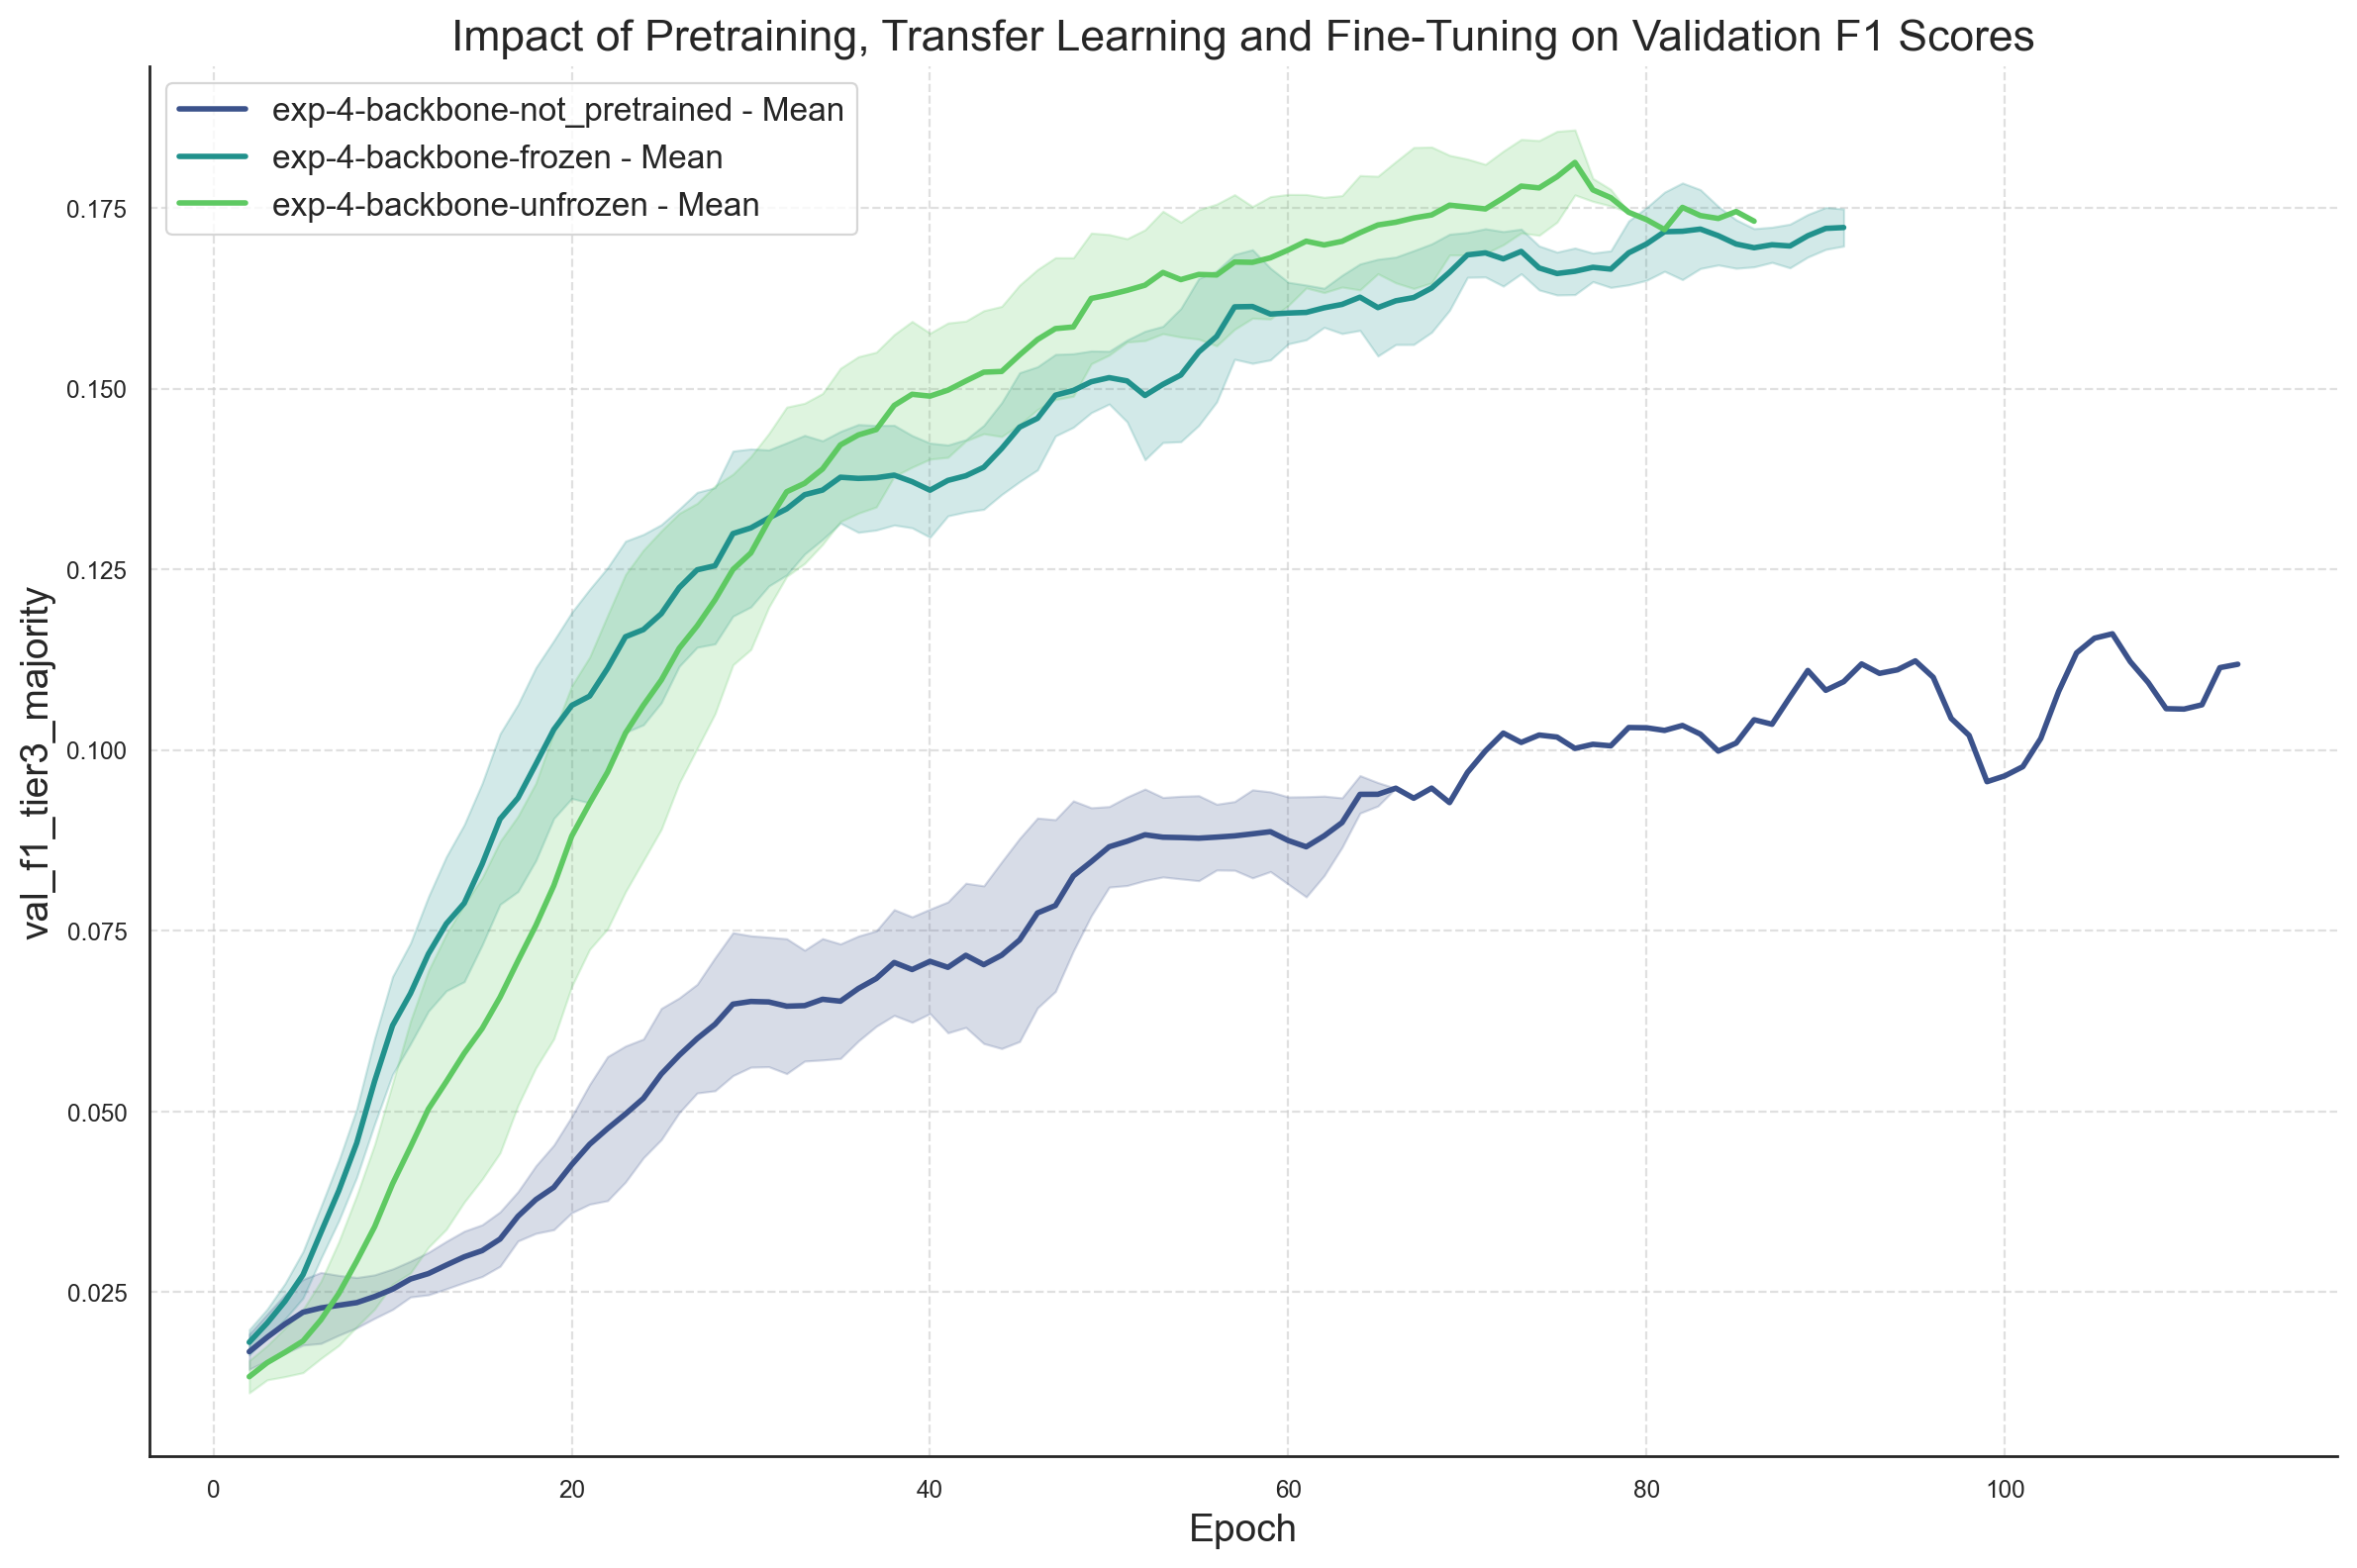

In [13]:
# Set up the plot using Seaborn's style
%config InlineBackend.figure_format='retina'

sns.set_theme(style="white", context="paper")

# Initialize the figure
plt.figure(figsize=(12, 8))

# Define the color palette
palette = sns.color_palette("viridis", len(runs_by_experiment))

# Plot each experiment group on the same plot
for color, (experiment_name, runs) in zip(palette, runs_by_experiment.items()):
    print(f"Processing {len(runs)} runs for experiment name {experiment_name}")
    
    f1s = []
    
    for run in runs:
        history = pd.DataFrame(list(run.scan_history(keys=[METRIC], page_size=500)))  # Fetching with a smaller batch size
        f1 = history[METRIC].values
        # Remove NaNs
        f1 = f1[~np.isnan(f1)]
        # Pad shorter runs with NaNs to align with the longest run
        if len(f1) < max_len:
            f1 = np.pad(f1, (0, max_len - len(f1)), 'constant', constant_values=np.nan)
        f1s.append(f1)

    f1s_for_band = np.array(f1s)
    
    if f1s_for_band.size == 0:  # Corrected check for empty data
        continue
    
    mean = np.nanmean(f1s_for_band, axis=0)
    std = np.nanstd(f1s_for_band, axis=0)

    # Calculate rolling mean and std
    rolling_mean = np.convolve(mean, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
    rolling_std = np.convolve(std, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')

    epochs = np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2)
    
    plt.plot(epochs, rolling_mean, label=f"{experiment_name} - Mean", color=color, linewidth=2)
    plt.fill_between(epochs, rolling_mean - rolling_std, rolling_mean + rolling_std, color=color, alpha=0.2)

# Customize the plot
plt.legend(loc="best", fontsize=12)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("$T_3$ F1 Score", fontsize=14)
plt.title(f"Impact of Pretraining, Transfer Learning and Fine-Tuning on Validation F1 Scores", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine(trim=False)
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
import wandb
import pandas as pd
import numpy as np

def compute_metrics(EXPERIMENT_GROUP, METRIC, ROLLING_WINDOW, TIMEOUT_SECONDS=120):
    # Initialize the W&B API with a longer timeout
    api = wandb.Api(timeout=TIMEOUT_SECONDS)

    # Fetch all runs
    runs = api.runs("crop-classification/messis", filters={"config.experiment_group": EXPERIMENT_GROUP})
    print(f"Found {len(runs)} runs for experiment group {EXPERIMENT_GROUP}")

    # Group runs by their experiment name
    runs_by_experiment = {}
    for run in runs:
        experiment_name = run.config.get('experiment_name', 'unknown')
        if experiment_name not in runs_by_experiment:
            runs_by_experiment[experiment_name] = []
        runs_by_experiment[experiment_name].append(run)

    # Drop experiment exp-4-backbone-not_pretrained-vles
    runs_by_experiment.pop('exp-4-backbone-not_pretrained-vles', None)

    # Find the maximum length of any run
    max_len = 0
    for runs in runs_by_experiment.values():
        for run in runs:
            history = pd.DataFrame(list(run.scan_history(keys=[METRIC], page_size=500)))  # Fetching with a smaller batch size
            max_len = max(max_len, len(history))

    # Compute rolling means and stds
    results = {}
    for experiment_name, runs in runs_by_experiment.items():
        print(f"Processing {len(runs)} runs for experiment name {experiment_name}")
        
        f1s = []
        
        for run in runs:
            history = pd.DataFrame(list(run.scan_history(keys=[METRIC], page_size=500)))  # Fetching with a smaller batch size
            f1 = history[METRIC].values
            # Remove NaNs
            f1 = f1[~np.isnan(f1)]
            # Pad shorter runs with NaNs to align with the longest run
            if len(f1) < max_len:
                f1 = np.pad(f1, (0, max_len - len(f1)), 'constant', constant_values=np.nan)
            f1s.append(f1)

        f1s_for_band = np.array(f1s)
        
        if f1s_for_band.size == 0:  # Skip if no valid data
            continue
        
        mean = np.nanmean(f1s_for_band, axis=0)
        std = np.nanstd(f1s_for_band, axis=0)

        # Calculate rolling mean and std
        rolling_mean = np.convolve(mean, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
        rolling_std = np.convolve(std, np.ones(ROLLING_WINDOW)/ROLLING_WINDOW, mode='valid')
        epochs = np.arange((ROLLING_WINDOW-1)/2, len(rolling_mean) + (ROLLING_WINDOW-1)/2)

        results[experiment_name] = {
            "epochs": epochs,
            "rolling_mean": rolling_mean,
            "rolling_std": rolling_std
        }

    return results

# Constants
EXPERIMENT_GROUP = "exp-4-backbone"
METRIC = "val_f1_tier3_majority"
ROLLING_WINDOW = 5 # Number of epochs to average over for the uncertainty band

# Compute the metrics
results = compute_metrics(EXPERIMENT_GROUP, METRIC, ROLLING_WINDOW)

Found 20 runs for experiment group exp-4-backbone
Processing 5 runs for experiment name exp-4-backbone-not_pretrained
Processing 5 runs for experiment name exp-4-backbone-frozen


/var/folders/8s/7zgyk05565q9l208ztk8spw80000gn/T/ipykernel_33326/3309891448.py:53: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(f1s_for_band, axis=0)


Processing 5 runs for experiment name exp-4-backbone-unfrozen


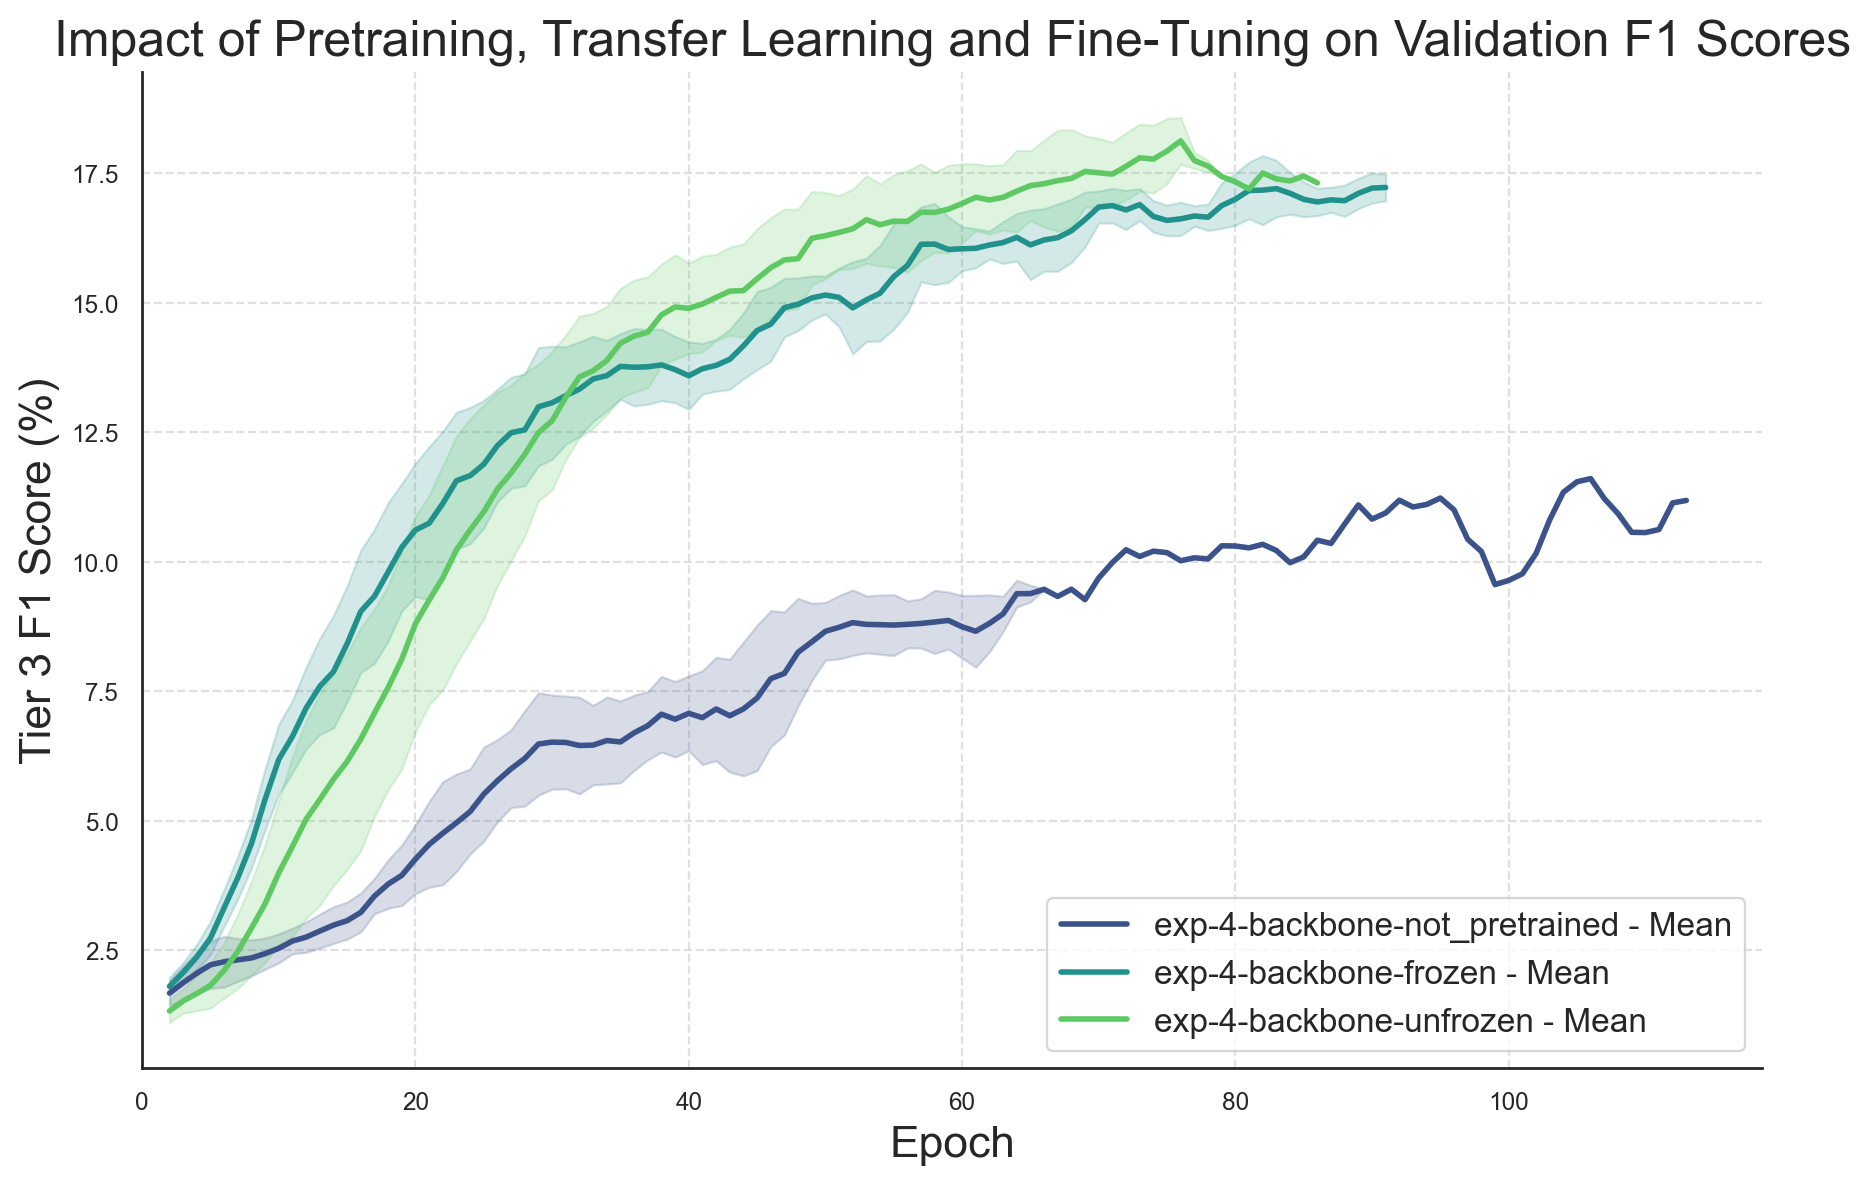

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'

def plot_metrics(results):
    # Set up the plot using Seaborn's style
    sns.set_theme(style="white", context="paper")

    # Initialize the figure
    plt.figure(figsize=(9, 6))

    # Define the color palette
    palette = sns.color_palette("viridis", len(results))

    # Plot each experiment group on the same plot
    for color, (experiment_name, metrics) in zip(palette, results.items()):
        # Convert F1 score to percentage
        rolling_mean_percentage = metrics['rolling_mean'] * 100
        rolling_std_percentage = metrics['rolling_std'] * 100
        
        plt.plot(metrics['epochs'], rolling_mean_percentage, label=f"{experiment_name} - Mean", color=color, linewidth=2)
        plt.fill_between(metrics['epochs'], rolling_mean_percentage - rolling_std_percentage, rolling_mean_percentage + rolling_std_percentage, color=color, alpha=0.2)

    # Customize the plot
    plt.legend(loc="best", fontsize=12)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("F1 Score (%) on Tier 3", fontsize=16)  # F1 Score now shown as percentage
    plt.title(f"Impact of Pretraining, Transfer Learning and Fine-Tuning on Validation F1 Scores", fontsize=18)
    plt.grid(True, linestyle='--', alpha=0.6)
    sns.despine(trim=False)
    plt.xlim(left=0)
    plt.tight_layout()


    # Show the plot
    plt.show()

# Plot the metrics
plot_metrics(results)
